In [1]:
!pip install duckdb --no-index --find-links=/kaggle/input/polars-and-duckdb/kaggle/working/mysitepackages/duck_pkg
!pip install python-gdcm
!pip install pylibjpeg
!pip install pylibjpeg-libjpeg==2.2.0
!pip install pylibjpeg-openjpeg==2.3.0
!pip install matplotlib==3.10.3
!pip install scikit-learn==1.7.0

Looking in links: /kaggle/input/polars-and-duckdb/kaggle/working/mysitepackages/duck_pkg
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 76.8 MB/s eta 0:00:00:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 32.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.1 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 56.5 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.2
    Uninstalling matplotlib-3.7.2:
      Successfully uninstalled matplotlib-3.7.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
ydata-profiling 4.16.1 requires matplotlib<=3.10,>=3.5, but you have matplotlib 3.10.3 which is incompatible.
bigframes 2.8.0

In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import os
import polars as pl
import duckdb as dd
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2
from pydicom import dcmread
import warnings
from sklearn.preprocessing import LabelEncoder
import pickle
import gc
import ctypes
from pathlib import Path
import logging
import json

In [7]:
pl.Config(fmt_str_lengths=1000)
pl.Config.set_tbl_rows(1000)

polars.config.Config

# Load the metadata of the training images
## Also separate out the localizer coordinates into individual columns

In [8]:
train_meta_data = pl.read_csv('/kaggle/input/rsna-intracranial-aneurysm-detection/train.csv'\
                              , low_memory=True)

train_locale_meta_data = pl.read_csv('/kaggle/input/rsna-intracranial-aneurysm-detection/train_localizers.csv'\
                              , low_memory=True)

def parse_coordinates(coord_str):
    if coord_str is None:
        return None, None
    try:
        coord_dict = json.loads(coord_str.replace("'", '"'))
        return float(coord_dict.get('x', 0.0)), float(coord_dict.get('y', 0.0))
    except (json.JSONDecodeError, KeyError, ValueError, AttributeError):
        return None, None

train_locale_meta_data = train_locale_meta_data.with_columns([
    pl.col("coordinates")
    .map_elements(lambda x: parse_coordinates(x)[0], return_dtype=pl.Float64)
    .cast(pl.Float64)
    .alias("coordinates_x"),
    
    pl.col("coordinates")
    .map_elements(lambda x: parse_coordinates(x)[1], return_dtype=pl.Float64)
    .cast(pl.Float64)
    .alias("coordinates_y")
])

print("Train CSV shape : ", train_meta_data.shape)
print("Train Localizers CSV shape : ", train_locale_meta_data.shape)
# Show the first few rows
print(train_locale_meta_data.select(["coordinates", "coordinates_x", "coordinates_y"]).head(5))

Train CSV shape :  (4405, 18)
Train Localizers CSV shape :  (2286, 6)
shape: (5, 3)
┌────────────────────────────────────────────────────┬───────────────┬───────────────┐
│ coordinates                                        ┆ coordinates_x ┆ coordinates_y │
│ ---                                                ┆ ---           ┆ ---           │
│ str                                                ┆ f64           ┆ f64           │
╞════════════════════════════════════════════════════╪═══════════════╪═══════════════╡
│ {'x': 258.3621186176837, 'y': 261.359900373599}    ┆ 258.362119    ┆ 261.3599      │
│ {'x': 194.87253141831238, 'y': 178.32675044883302} ┆ 194.872531    ┆ 178.32675     │
│ {'x': 189.23979878597123, 'y': 209.19184886465828} ┆ 189.239799    ┆ 209.191849    │
│ {'x': 208.2805049088359, 'y': 229.78962131837307}  ┆ 208.280505    ┆ 229.789621    │
│ {'x': 249.86745590416498, 'y': 220.623044646393}   ┆ 249.867456    ┆ 220.623045    │
└─────────────────────────────────────────────

In [9]:
train_meta_data.head(10)

SeriesInstanceUID,PatientAge,PatientSex,Modality,Left Infraclinoid Internal Carotid Artery,Right Infraclinoid Internal Carotid Artery,Left Supraclinoid Internal Carotid Artery,Right Supraclinoid Internal Carotid Artery,Left Middle Cerebral Artery,Right Middle Cerebral Artery,Anterior Communicating Artery,Left Anterior Cerebral Artery,Right Anterior Cerebral Artery,Left Posterior Communicating Artery,Right Posterior Communicating Artery,Basilar Tip,Other Posterior Circulation,Aneurysm Present
str,i64,str,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
"""1.2.826.0.1.3680043.8.498.10004044428023505108375152878107656647""",64,"""Female""","""MRA""",0,0,0,0,0,0,0,0,0,0,0,0,0,0
"""1.2.826.0.1.3680043.8.498.10004684224894397679901841656954650085""",76,"""Female""","""MRA""",0,0,0,0,0,0,0,0,0,0,0,0,0,0
"""1.2.826.0.1.3680043.8.498.10005158603912009425635473100344077317""",58,"""Male""","""CTA""",0,0,0,0,0,0,0,0,0,0,0,0,1,1
"""1.2.826.0.1.3680043.8.498.10009383108068795488741533244914370182""",71,"""Male""","""MRA""",0,0,0,0,0,0,0,0,0,0,0,0,0,0
"""1.2.826.0.1.3680043.8.498.10012790035410518400400834395242853657""",48,"""Female""","""MRA""",0,0,0,0,0,0,0,0,0,0,0,0,0,0
"""1.2.826.0.1.3680043.8.498.10014757658335054766479957992112625961""",53,"""Female""","""CTA""",0,0,0,0,0,0,0,0,0,0,0,0,0,0
"""1.2.826.0.1.3680043.8.498.10021411248005513321236647460239137906""",55,"""Female""","""CTA""",0,0,0,0,0,0,0,0,0,0,0,0,0,0
"""1.2.826.0.1.3680043.8.498.10022688097731894079510930966432818105""",51,"""Female""","""MRA""",0,0,0,0,0,0,0,0,0,0,0,0,0,0
"""1.2.826.0.1.3680043.8.498.10022796280698534221758473208024838831""",78,"""Male""","""CTA""",0,0,0,0,0,1,0,0,0,0,0,0,0,1


In [10]:
train_locale_meta_data.head(10)

SeriesInstanceUID,SOPInstanceUID,coordinates,location,coordinates_x,coordinates_y
str,str,str,str,f64,f64
"""1.2.826.0.1.3680043.8.498.10005158603912009425635473100344077317""","""1.2.826.0.1.3680043.8.498.10775329348174902199350466348663848346""","""{'x': 258.3621186176837, 'y': 261.359900373599}""","""Other Posterior Circulation""",258.362119,261.3599
"""1.2.826.0.1.3680043.8.498.10022796280698534221758473208024838831""","""1.2.826.0.1.3680043.8.498.53868409774237283281776807176852774246""","""{'x': 194.87253141831238, 'y': 178.32675044883302}""","""Right Middle Cerebral Artery""",194.872531,178.32675
"""1.2.826.0.1.3680043.8.498.10023411164590664678534044036963716636""","""1.2.826.0.1.3680043.8.498.24186535344744886473554579401056227253""","""{'x': 189.23979878597123, 'y': 209.19184886465828}""","""Right Middle Cerebral Artery""",189.239799,209.191849
"""1.2.826.0.1.3680043.8.498.10030095840917973694487307992374923817""","""1.2.826.0.1.3680043.8.498.75217084841854214544099244823406151875""","""{'x': 208.2805049088359, 'y': 229.78962131837307}""","""Right Infraclinoid Internal Carotid Artery""",208.280505,229.789621
"""1.2.826.0.1.3680043.8.498.10034081836061566510187499603024895557""","""1.2.826.0.1.3680043.8.498.71237104731452368587327801789352569583""","""{'x': 249.86745590416498, 'y': 220.623044646393}""","""Anterior Communicating Artery""",249.867456,220.623045
"""1.2.826.0.1.3680043.8.498.10035643165968342618460849823699311381""","""1.2.826.0.1.3680043.8.498.30083322134992576720636296296008654053""","""{'x': 223.66020358711827, 'y': 225.3447011195274}""","""Right Anterior Cerebral Artery""",223.660204,225.344701
"""1.2.826.0.1.3680043.8.498.10035643165968342618460849823699311381""","""1.2.826.0.1.3680043.8.498.46752468449107005352755579756056225731""","""{'x': 289.2376764288231, 'y': 211.78100912436958}""","""Left Middle Cerebral Artery""",289.237676,211.781009
"""1.2.826.0.1.3680043.8.498.10035643165968342618460849823699311381""","""1.2.826.0.1.3680043.8.498.14504961303532677815336995545201912867""","""{'x': 232.88987039309842, 'y': 226.4305401310092}""","""Right Supraclinoid Internal Carotid Artery""",232.88987,226.43054
"""1.2.826.0.1.3680043.8.498.10042423585566957032411171949972906248""","""1.2.826.0.1.3680043.8.498.63062558671948377310688873437936911318""","""{'x': 140.1086940862857, 'y': 177.63838968827815}""","""Right Middle Cerebral Artery""",140.108694,177.63839


In [11]:
# Get summary statistics of the new columns
print(train_locale_meta_data.select(["coordinates_x", "coordinates_y"]).describe())

shape: (9, 3)
┌────────────┬───────────────┬───────────────┐
│ statistic  ┆ coordinates_x ┆ coordinates_y │
│ ---        ┆ ---           ┆ ---           │
│ str        ┆ f64           ┆ f64           │
╞════════════╪═══════════════╪═══════════════╡
│ count      ┆ 2286.0        ┆ 2286.0        │
│ null_count ┆ 0.0           ┆ 0.0           │
│ mean       ┆ 250.984879    ┆ 215.891834    │
│ std        ┆ 68.854384     ┆ 53.991792     │
│ min        ┆ 0.339623      ┆ 5.0           │
│ 25%        ┆ 219.367003    ┆ 190.429365    │
│ 50%        ┆ 253.486724    ┆ 211.051486    │
│ 75%        ┆ 280.620123    ┆ 233.006627    │
│ max        ┆ 714.748844    ┆ 583.68        │
└────────────┴───────────────┴───────────────┘


# Get the image files for each training series and create a dataframe out of them

In [ ]:
allowed_tags = ['BitsAllocated', 'BitsStored', 'Rows', 'Columns', 'FrameOfReferenceUID', 'HighBit', 'ImageOrientationPatient'
                , 'ImagePositionPatient', 'InstanceNumber', 'Modality', 'PhotometricInterpretation'
                , 'PixelRepresentation', 'PixelSpacing', 'PlanarConfiguration', 'RescaleIntercept', 'RescaleSlope'
                , 'RescaleType', 'SamplesPerPixel', 'SliceThickness', 'SpacingBetweenSlices']

dicom_ds = dcmread(dcm_path)
for attr in dir(dicom_ds):
    ##if not attr.startswith('_') and attr != 'PixelData':  # Skip private attributes and pixel data
    if attr in allowed_tags:
        try:
            value = getattr(dicom_ds, attr)
            if not callable(value) and attr != 'pixel_array':
                print(f"{attr}: {value}")
        except AttributeError:
            continue

In [ ]:
def create_df_from_directory(main_folder_path, file_extension=".dcm"):
    main_path = Path(main_folder_path)
    
    if not main_path.exists():
        raise ValueError(f"Directory not found: {main_folder_path}")
    
    data = []
    
    try:
        # Get list of subfolders first to show progress
        subfolders = [f for f in main_path.iterdir() if f.is_dir()]
        
        # First progress bar for subfolders
        print("Processing directories...")
        for subfolder in tqdm(subfolders, desc="Processing folders"):
            series_instance_uid = subfolder.name
            
            # Get all matching files in this subfolder
            files = list(subfolder.glob(f"*{file_extension}"))
            if not files:
                logging.warning(f"No {file_extension} files found in {subfolder}")
                continue
            
            # Add all files from this subfolder
            for file_path in files:
                try:
                    ds = dcmread(str(file_path))
                    row = {'series_instance_uid': series_instance_uid,'dcm_file_name': file_path.name}
                    for tag in allowed_tags:
                        try:
                            value = getattr(ds, tag)
                            if hasattr(value, '__iter__') and not isinstance(value, str):
                                value = list(map(float, value))
                            row[tag] = value
                        except (AttributeError, TypeError):
                            row[tag] = None
                    data.append(row)
                except Exception as e:
                    print(f"Error processing {file_path}: {e}")
                    continue
                #data.append((series_instance_uid, file_path.name))
        
        if not data:
            logging.warning("No files found matching the criteria")
            return pl.DataFrame(schema=["series_instance_uid", "dcm_file_name"])
        
        print("\nCreating DataFrame...")
        df = pl.DataFrame(
            data,
            orient="row"
        )
        
        return df
    
    except Exception as e:
        logging.error(f"Error processing directory: {e}")
        raise

# Usage with error handling
try:
    df_all = create_df_from_directory("/kaggle/input/rsna-intracranial-aneurysm-detection/series")
    
    # Print summary
    print(f"Total files found: {len(df_all)}")
    print("\nFirst few rows:")
    print(df_all.head())
    
    # Optional: Get counts per SOPInstanceUID
    #print("\nFiles per SeriesInstanceUID:")
    #print(df_all.group_by("SeriesInstanceUID").count().sort("count", descending=True))
    
except Exception as e:
    print(f"Error: {e}")

Processing directories...


Processing folders:   9%|▉         | 399/4405 [13:16<1:36:12,  1.44s/it]

# Create the full training data
* Standardize the column names
* Bring in the localizer coordinates for the series where aneurysm is present
* Create another column to signify whether aneurysm is shown in a specific image within a series
* There can be cases where some images of a series cannot catch aneurysm presence
* Bringing all the rows at the image file granularity, i.e. if a file has coordinates then it has aneurysm else not

In [14]:
new_columns = [col.lower().replace(" ", "_") for col in train_meta_data.columns]
train_meta_data.columns = new_columns
print(train_meta_data.columns)

['seriesinstanceuid', 'patientage', 'patientsex', 'modality', 'left_infraclinoid_internal_carotid_artery', 'right_infraclinoid_internal_carotid_artery', 'left_supraclinoid_internal_carotid_artery', 'right_supraclinoid_internal_carotid_artery', 'left_middle_cerebral_artery', 'right_middle_cerebral_artery', 'anterior_communicating_artery', 'left_anterior_cerebral_artery', 'right_anterior_cerebral_artery', 'left_posterior_communicating_artery', 'right_posterior_communicating_artery', 'basilar_tip', 'other_posterior_circulation', 'aneurysm_present']


In [53]:
df_all_coordinates = dd.sql( \
    "select t2.coordinates_x, t2.coordinates_y, t1.* \
    from df_all t1 \
    left join train_locale_meta_data t2 \
    on t1.SeriesInstanceUID = t2.SeriesInstanceUID \
    and replace(t1.dcm_file_name, '.dcm','') = t2.SOPInstanceUID "\
).pl()

df_all_data = dd.sql( \
    "select t2.dcm_file_name, t2.coordinates_x, t2.coordinates_y \
    , t1.aneurysm_present as aneurysm_present_in_series \
    , case when t2.coordinates_x is not null then 1 else 0 end as aneurysm_present_in_image \
    , t1.seriesinstanceuid, t1.patientage, t1.patientsex, t1.modality \
    , case when t2.coordinates_x is not null then t1.left_infraclinoid_internal_carotid_artery \
    else 0 end as left_infraclinoid_internal_carotid_artery \
    , case when t2.coordinates_x is not null then t1.right_infraclinoid_internal_carotid_artery \
    else 0 end as right_infraclinoid_internal_carotid_artery \
    , case when t2.coordinates_x is not null then t1.left_supraclinoid_internal_carotid_artery \
    else 0 end as left_supraclinoid_internal_carotid_artery \
    , case when t2.coordinates_x is not null then t1.right_supraclinoid_internal_carotid_artery \
    else 0 end as right_supraclinoid_internal_carotid_artery \
    , case when t2.coordinates_x is not null then t1.left_middle_cerebral_artery \
    else 0 end as left_middle_cerebral_artery \
    , case when t2.coordinates_x is not null then t1.right_middle_cerebral_artery \
    else 0 end as right_middle_cerebral_artery \
    , case when t2.coordinates_x is not null then t1.anterior_communicating_artery \
    else 0 end as anterior_communicating_artery \
    , case when t2.coordinates_x is not null then t1.left_anterior_cerebral_artery \
    else 0 end as left_anterior_cerebral_artery \
    , case when t2.coordinates_x is not null then t1.right_anterior_cerebral_artery \
    else 0 end as right_anterior_cerebral_artery \
    , case when t2.coordinates_x is not null then t1.left_posterior_communicating_artery \
    else 0 end as left_posterior_communicating_artery \
    , case when t2.coordinates_x is not null then t1.right_posterior_communicating_artery \
    else 0 end as right_posterior_communicating_artery \
    , case when t2.coordinates_x is not null then t1.basilar_tip \
    else 0 end as basilar_tip \
    , case when t2.coordinates_x is not null then t1.other_posterior_circulation \
    else 0 end as other_posterior_circulation \
    from train_meta_data t1 \
    join df_all_coordinates t2 \
    on t1.SeriesInstanceUID = t2.SeriesInstanceUID" \
).pl()

print("Full training data: ", df_all_data.shape)
print("Aneurysm not present in {0} series".format(df_all_data.filter(pl.col("coordinates_x").is_null()).shape[0]))

print("Aneurysm present in {0} series".format(df_all_data.filter(pl.col("coordinates_x").is_not_null()).shape[0]))

print("Aneurysm not shown in {0} images".format(df_all_data.filter(pl.col("aneurysm_present_in_image")==0).shape[0]))

print("Aneurysm shown in {0} images".format(df_all_data.filter(pl.col("aneurysm_present_in_image")==1).shape[0]))

print(df_all_data.select(["coordinates_x", "coordinates_y"]).describe())

Full training data:  (1012308, 22)
Aneurysm not present in 1010022 series
Aneurysm present in 2286 series
Aneurysm not shown in 1010022 images
Aneurysm shown in 2286 images
shape: (9, 3)
┌────────────┬───────────────┬───────────────┐
│ statistic  ┆ coordinates_x ┆ coordinates_y │
│ ---        ┆ ---           ┆ ---           │
│ str        ┆ f64           ┆ f64           │
╞════════════╪═══════════════╪═══════════════╡
│ count      ┆ 2286.0        ┆ 2286.0        │
│ null_count ┆ 1.010022e6    ┆ 1.010022e6    │
│ mean       ┆ 250.984879    ┆ 215.891834    │
│ std        ┆ 68.854384     ┆ 53.991792     │
│ min        ┆ 0.339623      ┆ 5.0           │
│ 25%        ┆ 219.367003    ┆ 190.429365    │
│ 50%        ┆ 253.486724    ┆ 211.051486    │
│ 75%        ┆ 280.620123    ┆ 233.006627    │
│ max        ┆ 714.748844    ┆ 583.68        │
└────────────┴───────────────┴───────────────┘


# Looking at a specific CTA image that shows aneurysm

In [55]:
df_all_data.filter(
    (pl.col("seriesinstanceuid") == '1.2.826.0.1.3680043.8.498.10005158603912009425635473100344077317')
    &
    (pl.col('coordinates_x').is_null())
)

dcm_file_name,coordinates_x,coordinates_y,aneurysm_present_in_series,aneurysm_present_in_image,seriesinstanceuid,patientage,patientsex,modality,left_infraclinoid_internal_carotid_artery,right_infraclinoid_internal_carotid_artery,left_supraclinoid_internal_carotid_artery,right_supraclinoid_internal_carotid_artery,left_middle_cerebral_artery,right_middle_cerebral_artery,anterior_communicating_artery,left_anterior_cerebral_artery,right_anterior_cerebral_artery,left_posterior_communicating_artery,right_posterior_communicating_artery,basilar_tip,other_posterior_circulation
str,f64,f64,i64,i32,str,i64,str,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
"""1.2.826.0.1.3680043.8.498.58334356826282405251637348211024908386.dcm""",null,null,1,0,"""1.2.826.0.1.3680043.8.498.10005158603912009425635473100344077317""",58,"""Male""","""CTA""",0,0,0,0,0,0,0,0,0,0,0,0,0
"""1.2.826.0.1.3680043.8.498.53317261777463781913369232783277583672.dcm""",null,null,1,0,"""1.2.826.0.1.3680043.8.498.10005158603912009425635473100344077317""",58,"""Male""","""CTA""",0,0,0,0,0,0,0,0,0,0,0,0,0
"""1.2.826.0.1.3680043.8.498.12434113892888193690897112314672215727.dcm""",null,null,1,0,"""1.2.826.0.1.3680043.8.498.10005158603912009425635473100344077317""",58,"""Male""","""CTA""",0,0,0,0,0,0,0,0,0,0,0,0,0
"""1.2.826.0.1.3680043.8.498.15998889926081338350520190735046343077.dcm""",null,null,1,0,"""1.2.826.0.1.3680043.8.498.10005158603912009425635473100344077317""",58,"""Male""","""CTA""",0,0,0,0,0,0,0,0,0,0,0,0,0
"""1.2.826.0.1.3680043.8.498.70865052058912089845214555043799776773.dcm""",null,null,1,0,"""1.2.826.0.1.3680043.8.498.10005158603912009425635473100344077317""",58,"""Male""","""CTA""",0,0,0,0,0,0,0,0,0,0,0,0,0
"""1.2.826.0.1.3680043.8.498.91273885413248569304096665804712620424.dcm""",null,null,1,0,"""1.2.826.0.1.3680043.8.498.10005158603912009425635473100344077317""",58,"""Male""","""CTA""",0,0,0,0,0,0,0,0,0,0,0,0,0
"""1.2.826.0.1.3680043.8.498.54516279607596941305647994413776219146.dcm""",null,null,1,0,"""1.2.826.0.1.3680043.8.498.10005158603912009425635473100344077317""",58,"""Male""","""CTA""",0,0,0,0,0,0,0,0,0,0,0,0,0
"""1.2.826.0.1.3680043.8.498.61507183751312521040338627181609013858.dcm""",null,null,1,0,"""1.2.826.0.1.3680043.8.498.10005158603912009425635473100344077317""",58,"""Male""","""CTA""",0,0,0,0,0,0,0,0,0,0,0,0,0
"""1.2.826.0.1.3680043.8.498.10434450479638976545874654806065977301.dcm""",null,null,1,0,"""1.2.826.0.1.3680043.8.498.10005158603912009425635473100344077317""",58,"""Male""","""CTA""",0,0,0,0,0,0,0,0,0,0,0,0,0


In [37]:
# Version with zoom functionality
def load_and_view_single_slice_with_zoom(dcm_path, x_coord, y_coord, zoom_size=100):
    """
    Load and display a single DICOM slice with crosshair and zoomed inset
    
    Args:
        dcm_path: Path to the DICOM file
        x_coord: x coordinate for the crosshair
        y_coord: y coordinate for the crosshair
        zoom_size: Size of the zoom window in pixels
    """
    # Read DICOM file
    ds = dcmread(dcm_path)
    img = ds.pixel_array
    
    # Create figure and axes
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
    
    # Main image with crosshair
    ax1.imshow(img, cmap='gray')
    ax1.axvline(x=x_coord, color='red', alpha=0.5)
    ax1.axhline(y=y_coord, color='red', alpha=0.5)
    ax1.plot(x_coord, y_coord, 'r+', markersize=10, markeredgewidth=2)
    
    # Zoomed region
    x_start = int(max(0, x_coord - zoom_size/2))
    x_end = int(min(img.shape[1], x_coord + zoom_size/2))
    y_start = int(max(0, y_coord - zoom_size/2))
    y_end = int(min(img.shape[0], y_coord + zoom_size/2))
    
    zoomed = img[y_start:y_end, x_start:x_end]
    ax2.imshow(zoomed, cmap='gray')
    
    # Add crosshair to zoomed region
    center_x = x_coord - x_start
    center_y = y_coord - y_start
    ax2.axvline(x=center_x, color='red', alpha=0.5)
    ax2.axhline(y=center_y, color='red', alpha=0.5)
    ax2.plot(center_x, center_y, 'r+', markersize=10, markeredgewidth=2)
    
    ax1.axis('off')
    ax2.axis('off')
    ax1.set_title('Full Image')
    ax2.set_title('Zoomed Region')
    
    plt.tight_layout()
    plt.show()

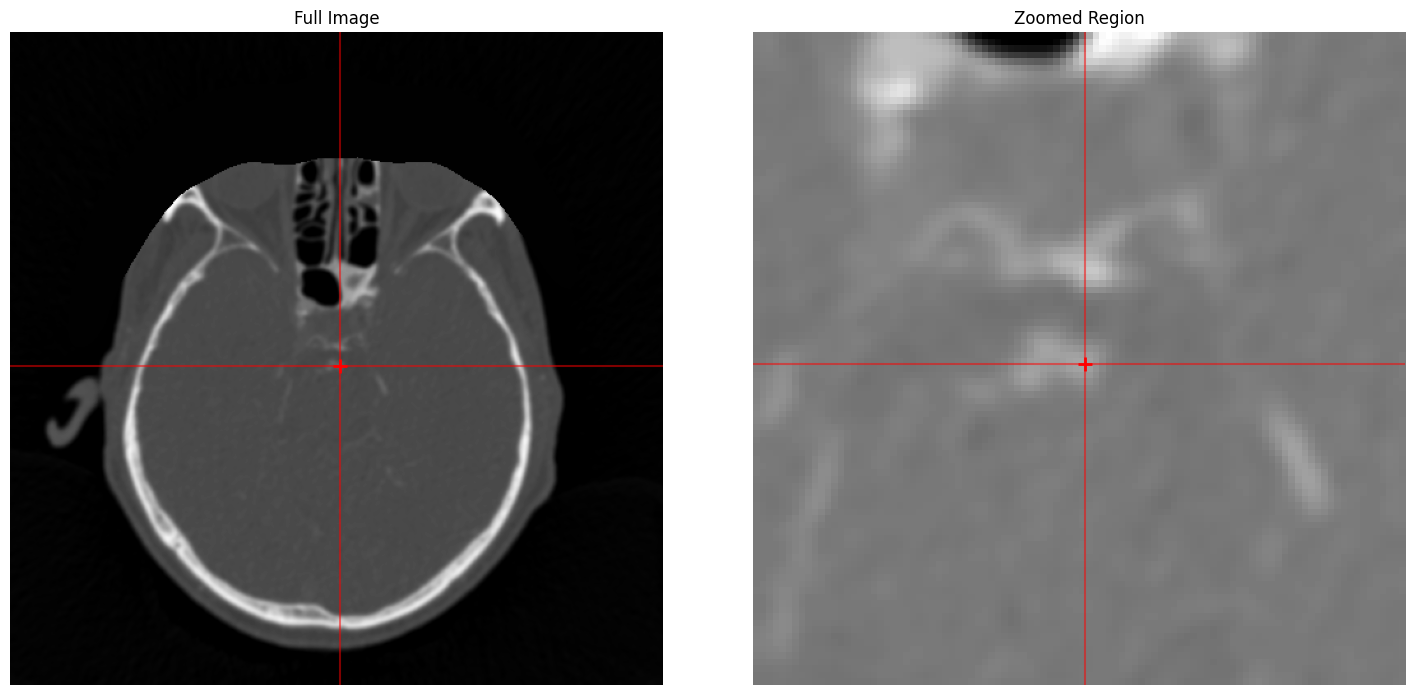

In [52]:
dcm_path = '/kaggle/input/rsna-intracranial-aneurysm-detection/series/1.2.826.0.1.3680043.8.498.10005158603912009425635473100344077317/1.2.826.0.1.3680043.8.498.10775329348174902199350466348663848346.dcm'
x_coord = 258.362119
y_coord = 261.3599
load_and_view_single_slice_with_zoom(dcm_path, x_coord, y_coord)

In [44]:
dicom_ds = dcmread(dcm_path)
print(dicom_ds.pixel_array.shape)

(512, 512)


In [56]:
allowed_tags = ['BitsAllocated', 'BitsStored', 'Rows', 'Columns', 'FrameOfReferenceUID', 'HighBit', 'ImageOrientationPatient'
                , 'ImagePositionPatient', 'InstanceNumber', 'Modality', 'PhotometricInterpretation'
                , 'PixelRepresentation', 'PixelSpacing', 'PlanarConfiguration', 'RescaleIntercept', 'RescaleSlope'
                , 'RescaleType', 'SamplesPerPixel', 'SliceThickness', 'SpacingBetweenSlices']

dicom_ds = dcmread(dcm_path)
for attr in dir(dicom_ds):
    ##if not attr.startswith('_') and attr != 'PixelData':  # Skip private attributes and pixel data
    if attr in allowed_tags:
        try:
            value = getattr(dicom_ds, attr)
            #if not callable(value) and attr != 'pixel_array':
            print(f"{attr}: {value}")
        except AttributeError:
            continue

BitsAllocated: 16
BitsStored: 16
Columns: 512
FrameOfReferenceUID: 1.2.826.0.1.3680043.10.474.2.961932.13226
HighBit: 15
ImageOrientationPatient: [1, 0, 0, 0, 1, 0]
ImagePositionPatient: [-112.2802734375, -279.7802734375, -97]
InstanceNumber: 163
Modality: CT
PhotometricInterpretation: MONOCHROME2
PixelRepresentation: 1
PixelSpacing: [0.439453125, 0.439453125]
PlanarConfiguration: 0
RescaleType: HU
Rows: 512
SamplesPerPixel: 1
SliceThickness: 0.6


## Checking the cardinality of the different type of image modalities

In [26]:
dd.sql("select modality, count(1) as image_count from df_all_data group by modality").pl()

modality,image_count
str,i64
"""CTA""",737343
"""MRA""",197229
"""MRI T2""",30409
"""MRI T1post""",47327


# Checking for different Image array shapes

In [47]:
root_file_path = '/kaggle/input/rsna-intracranial-aneurysm-detection/series/'

def get_image_array_shape(seriesinstanceuid, dcm_file_name):
    image_path = root_file_path + seriesinstanceuid + '/' + dcm_file_name
    dicom_ds = dcmread(image_path)
    return str(dicom_ds.pixel_array.shape)

vectorized_process = np.vectorize(get_image_array_shape, otypes=[object])

df_all_data = df_all_data.with_columns(
    pl.Series(
        name="img_array_shape_tuple",
        values=vectorized_process(
            df_all_data["seriesinstanceuid"].to_numpy(),
            df_all_data["dcm_file_name"].to_numpy()
        )
    )
)

KeyboardInterrupt: 

In [22]:
temp_df = dd.sql("select modality, img_array_shape_tuple, count(distinct(seriesinstanceuid)) as series_count \
, count(distinct(dcm_file_name)) as image_count \
from df_all_data group by modality, img_array_shape_tuple order by 4 desc").pl()

In [38]:
grouped_df = temp_df.group_by(['Modality', 'img_array_shape_tuple']).agg([
        pl.col('series_count').sum().alias('total_series'),
        pl.col('image_count').sum().alias('total_images')
    ]).filter(
        (pl.col('total_series') > 20) | (pl.col('total_images') > 20)
    ).sort('total_images', descending=True)

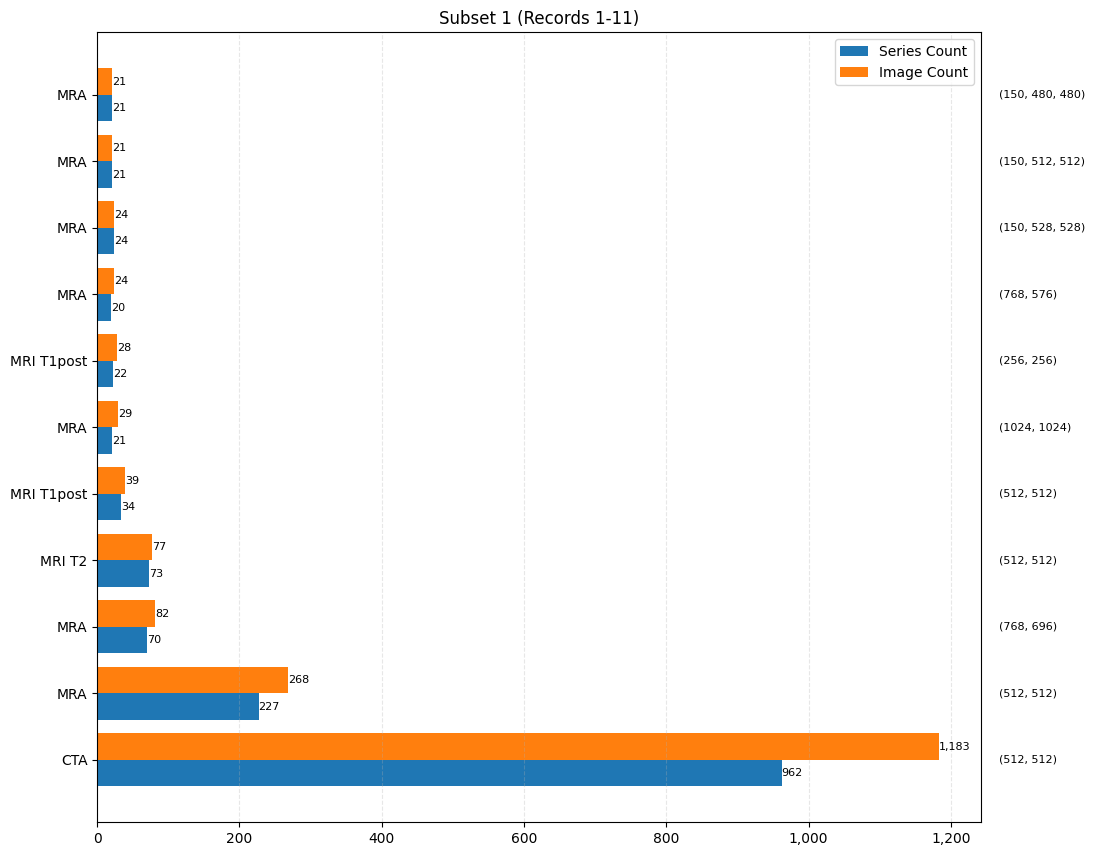

In [39]:
# Convert to pandas for easier plotting with matplotlib
pdf = grouped_df.to_pandas()

# Calculate number of subplots needed
records_per_plot = 30
total_records = len(pdf)
num_plots = (total_records + records_per_plot - 1) // records_per_plot  # Ceiling division

# Create subplots
fig, axes = plt.subplots(3, 2, figsize=(20, 25))  # 3x2 grid for 6 subplots
axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

# Color scheme
series_color = '#1f77b4'  # Blue
images_color = '#ff7f0e'  # Orange

# Format numbers with comma as thousand separator
def format_number(x):
    return f'{int(x):,}'

# Plot each subset of data
for plot_idx in range(num_plots):
    ax = axes[plot_idx]
    
    # Get the slice of data for this subplot
    start_idx = plot_idx * records_per_plot
    end_idx = min(start_idx + records_per_plot, total_records)
    plot_data = pdf.iloc[start_idx:end_idx]
    
    # Create horizontal bars
    y_pos = np.arange(len(plot_data))
    
    # Plot series count
    series_bars = ax.barh(y_pos - 0.2, plot_data['total_series'], 
                         height=0.4, color=series_color, label='Series Count')
    
    # Plot image count
    image_bars = ax.barh(y_pos + 0.2, plot_data['total_images'], 
                        height=0.4, color=images_color, label='Image Count')
    
    # Customize the plot
    ax.set_yticks(y_pos)
    ax.set_yticklabels(plot_data['Modality'])
    
    # Add value labels on the bars
    for bars in [series_bars, image_bars]:
        for bar in bars:
            width = bar.get_width()
            ax.text(width, bar.get_y() + bar.get_height()/2,
                   format_number(width),
                   ha='left', va='center', fontsize=8)
    
    # Add shape information as text on the right side
    for idx, (shape, series, images) in enumerate(zip(plot_data['img_array_shape_tuple'], 
                                                     plot_data['total_series'],
                                                     plot_data['total_images'])):
        ax.text(1.02, idx, shape, transform=ax.get_yaxis_transform(),
                ha='left', va='center', fontsize=8)
    
    # Add legend only to the first subplot
    if plot_idx == 0:
        ax.legend()
    
    # Add title
    ax.set_title(f'Subset {plot_idx + 1} (Records {start_idx + 1}-{end_idx})')
    
    # Add grid
    ax.grid(True, axis='x', linestyle='--', alpha=0.3)
    
    # Format x-axis with comma as thousand separator
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format_number(x)))

# Remove any empty subplots
for idx in range(num_plots, len(axes)):
    fig.delaxes(axes[idx])

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
def validate_aneurysm_data(df):
    """
    Validate that for each combination of SeriesInstanceUID, PatientAge, PatientSex, and Modality,
    exactly one of the aneurysm location columns has value 1 and the rest have value 0.
    
    Parameters:
    df (polars.DataFrame): DataFrame with the specified columns
    
    Returns:
    dict: Validation results including violations and summary statistics
    """
    
    # Define the grouping columns (first 4 columns)
    grouping_cols = ['SeriesInstanceUID', 'PatientAge', 'PatientSex', 'Modality']
    
    # Define the aneurysm location columns (remaining 13 columns)
    aneurysm_cols = [
        'Left Infraclinoid Internal Carotid Artery',
        'Right Infraclinoid Internal Carotid Artery',
        'Left Supraclinoid Internal Carotid Artery',
        'Right Supraclinoid Internal Carotid Artery',
        'Left Middle Cerebral Artery',
        'Right Middle Cerebral Artery',
        'Anterior Communicating Artery',
        'Left Anterior Cerebral Artery',
        'Right Anterior Cerebral Artery',
        'Left Posterior Communicating Artery',
        'Right Posterior Communicating Artery',
        'Basilar Tip',
        'Other Posterior Circulation'
    ]
    
    # Check if 'Aneurysm Present' should be included in the validation
    #if 'Aneurysm Present' in df.columns:
    #    aneurysm_cols.append('Aneurysm Present')
    
    print(f"Validating {len(aneurysm_cols)} aneurysm location columns...")
    print(f"Aneurysm columns: {aneurysm_cols}")
    
    # Group by the first 4 columns and sum the aneurysm location columns
    grouped = df.group_by(grouping_cols).agg([
        pl.col(col).sum().alias(f"{col}_sum") for col in aneurysm_cols
    ])
    
    # Calculate the total sum for each group (should be 1 for valid records)
    sum_cols = [f"{col}_sum" for col in aneurysm_cols]
    grouped = grouped.with_columns([
        pl.sum_horizontal(sum_cols).alias('total_aneurysm_count')
    ])
    
    # Find violations (where total is not equal to 1)
    violations = grouped.filter(pl.col('total_aneurysm_count') != 1)
    
    # Separate different types of violations
    zero_violations = grouped.filter(pl.col('total_aneurysm_count') == 0)  # No aneurysm marked
    multiple_violations = grouped.filter(pl.col('total_aneurysm_count') > 1)  # Multiple aneurysms marked
    
    # Create summary statistics
    total_groups = grouped.height
    valid_groups = grouped.filter(pl.col('total_aneurysm_count') == 1).height
    invalid_groups = violations.height
    
    results = {
        'total_groups': total_groups,
        'valid_groups': valid_groups,
        'invalid_groups': invalid_groups,
        'validation_passed': invalid_groups == 0,
        'zero_violations': zero_violations.height,
        'multiple_violations': multiple_violations.height,
        'violations_data': violations,
        'zero_violations_data': zero_violations,
        'multiple_violations_data': multiple_violations
    }
    
    return results

def print_validation_summary(results):
    """Print a summary of the validation results."""
    print("\n" + "="*60)
    print("ANEURYSM DATA VALIDATION SUMMARY")
    print("="*60)
    
    print(f"Total unique combinations: {results['total_groups']}")
    print(f"Valid combinations: {results['valid_groups']}")
    print(f"Invalid combinations: {results['invalid_groups']}")
    print(f"Validation passed: {results['validation_passed']}")
    
    if results['invalid_groups'] > 0:
        print(f"\nTypes of violations:")
        print(f"- No aneurysm marked (sum = 0): {results['zero_violations']}")
        print(f"- Multiple aneurysms marked (sum > 1): {results['multiple_violations']}")
        
        print(f"\nValidation accuracy: {results['valid_groups']/results['total_groups']*100:.2f}%")

def show_violation_details(results, max_violations=10):
    """Show detailed information about violations."""
    
    if results['zero_violations'] > 0:
        print(f"\n{'='*40}")
        print("RECORDS WITH NO ANEURYSM MARKED (sum = 0)")
        print(f"{'='*40}")
        print(results['zero_violations_data'].head(max_violations))
    
    if results['multiple_violations'] > 0:
        print(f"\n{'='*40}")
        print("RECORDS WITH MULTIPLE ANEURYSMS MARKED (sum > 1)")
        print(f"{'='*40}")
        print(results['multiple_violations_data'].head(max_violations))

In [ ]:
results = validate_aneurysm_data(df_aneurysm_present)

In [ ]:
print_validation_summary(results)

In [ ]:
if results['invalid_groups'] > 0:
        show_violation_details(results)

In [ ]:
dd.sql("select * from df_aneurysm_present \
where SeriesInstanceUID = '1.2.826.0.1.3680043.8.498.74614921932700985358270443944241418147' ").pl()